# Visualising outbreak curves

## Reading and cleaning  the data

Import things

In [2]:
#%reset # ensures I am starting from scratch when appending dataframes

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt
from os.path import isfile, join
from glob import glob

import seaborn as sns
sns.set(style="darkgrid")

In [28]:
#set file paths

path = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/"
path_raw = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/raw/"
path_raw_input = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\raw/"
path_output = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/direct_output/sensitivity_analysis/ema_workbench_10m/"

Identify the input files and read them in

### Comparing different seed results on same run

Sets of simulation results can also be explored in the aggregate.

In [47]:
outputFiles = ["exportMe989510m.txt", "exportMe198010m.txt", "exportMe897310m.txt", 
               "exportMe228910m.txt", "exportMe348110m.txt", "exportMe491510m.txt", 
               "exportMe737410m.txt", "exportMe674510m.txt", "exportMe58010m.txt", 
               "exportMe514210m.txt"] 

import re #enables multiple split criteria in one string


#define the parameters to go into the function
for x in outputFiles :
    exportMe = pd.read_csv(path_output+x, sep='\t')
    exportMe['districtId'] = [int(str(x).split('_')[1]) for x in exportMe["myId"]] 
    exportMe['seed'] = (re.split('Me|.txt', x)[1]) 
    exportMe = exportMe.drop('Unnamed: 8', axis=1)
    exportMe.reset_index(drop=True)
    exportMe.to_csv(path_output+'to_append'+x)

    
seed = '9895'
beta = 0.016
run_length = 180  


# for x in outputFiles:
#     print(x.split('/'))
exportMe.head()


,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,districtId,seed
0,0,d_38,0,0,0,0,0,0,38,514210m
1,0,d_39,0,0,0,0,0,0,39,514210m
2,0,d_47,0,0,0,0,0,0,47,514210m
3,0,d_48,0,0,0,0,2,0,48,514210m
4,0,d_45,0,0,0,0,0,0,45,514210m


In [67]:
#append all files with different seeds outputs together (run at the end when all are created)
exports = glob(path_output+'to_append*')

exports.sort()

ema_exports = pd.concat((pd.read_csv(export, sep='\t') for export in exports), ignore_index=False)

# export to csv
ema_exports.to_csv(path_output+'ema_appended_all_cols.csv', sep='\t')
ema_exports= pd.read_csv(path_output+'ema_appended_all_cols.csv', sep=',')

# create a scaled up variable of cases and deaths x20
ema_exports['scaled_sim_cases']=ema_exports['metric_new_cases_sympt'] *20
ema_exports['scaled_sim_deaths']=ema_exports['metric_new_deaths' ] *20
ema_exports['scaled_cum_deaths']=ema_exports['metric_died_count']*20



## Make graphs with multiple lines

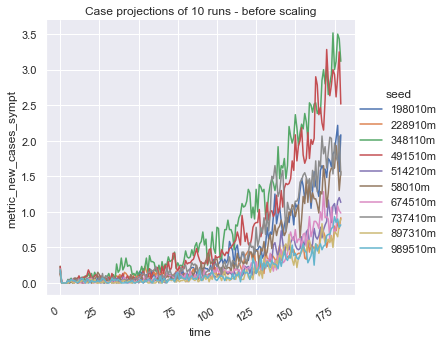

In [66]:
g = sns.relplot(x="time", y="metric_new_cases_sympt", kind="line", hue="seed", ci=None, data=ema_exports).set(title="Case projections of 10 runs - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_cases_10runs.png')

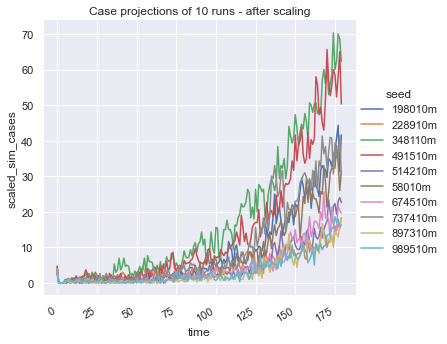

In [68]:
g = sns.relplot(x="time", y="scaled_sim_cases", kind="line", hue="seed", ci=None, data=ema_exports).set(title="Case projections of 10 runs - after scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_cases_scaled_10runs.png')

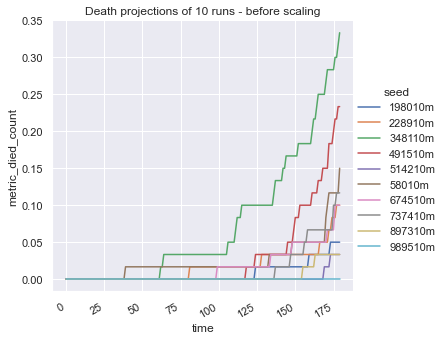

In [65]:
g = sns.relplot(x="time", y="metric_died_count", kind="line", hue="seed", ci=None, data=ema_exports).set(title="Death projections of 10 runs - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_deaths_10runs.png')

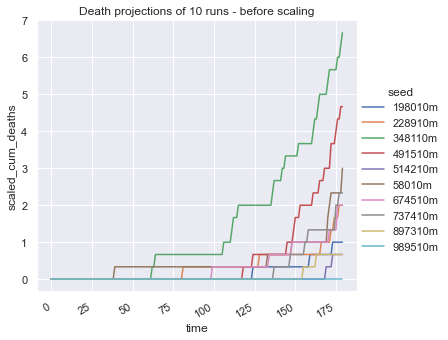

In [69]:
g = sns.relplot(x="time", y="scaled_cum_deaths", kind="line", hue="seed", ci=None, data=ema_exports).set(title="Death projections of 10 runs - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_deaths_scaled_10runs.png')

### process first case files 

In [71]:
                  
# keeping only where the number of either symptomatic or asymptomatic is >0
cases = ema_exports[(ema_exports.metric_new_cases_sympt > 0) | (ema_exports.metric_new_cases_asympt > 0)]
cases = cases.drop('\t', axis=1)
cases.head()


,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,districtId,seed,scaled_sim_cases,scaled_sim_deaths,scaled_cum_deaths
3,0,d_48,0,0,0,1,1,0,48,198010m,20,0,0
8,0,d_2,0,0,0,3,5,0,2,198010m,100,0,0
10,0,d_1,0,0,0,2,0,0,1,198010m,0,0,0
31,0,d_18,0,0,0,4,4,0,18,198010m,80,0,0
308,5,d_2,0,0,0,1,0,0,2,198010m,0,0,0


In [104]:
# keep the min time value by district equivalent to first case by district 
byDistric = cases.groupby(['seed','districtId']).agg({'time': 'min'})
byDistric.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
byDistric.rename(columns={'time':'simDay_firstcase'}, inplace=True)

#add variables to denote seed of the run, beta value & no. days
byDistric['beta'] = beta
byDistric['run_length']= run_length

#create a dataframe of this that I can aggregate afterwards
byDistric.to_csv(path_output+'first_cases_10runs.csv')
byDistric.reset_index(level=['districtId','seed'], inplace=True)
byDistric.head()

,seed,districtId,simDay_firstcase,beta,run_length
0,198010m,1,0,0.016,180
1,198010m,2,0,0.016,180
2,198010m,3,84,0.016,180
3,198010m,4,121,0.016,180
4,198010m,5,154,0.016,180


In [105]:
# read in the first districts cases data (what she called 'gold standard data')
gold_filename = (path+"../preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## this has just made another variable for the true day which is int format 
g_data.head()

,day,districtId,district_name_shpfile,cases_by_district_per_day,tot_cases_by_district,trueDay
0,1,1,Bulawayo,1,1044,1
1,5,18,Goromonzi,1,35,5
2,35,26,Chegutu,3,104,35
3,40,21,Murehwa,1,26,40
4,57,17,Chikomba,1,17,57


In [136]:
# m:1 merge on this data (in true/gold data, we have all 60 districts uniquely)
# note the gold data will get replicated across all 10 seeds if works correctly
# join the simulated and gold standard data based on the district ID
ema_plus_gold = pd.merge (byDistric, g_data, on = 'districtId', how='outer', validate='many_to_one')
ema_plus_gold.head(20)

# for the true first days for which there are multiple districts, I need to separate them out. e.g. day 1: Harare=1.1 + Buluwayo=1.2

ema_plus_gold['trueDay_sep']= ema_plus_gold['day'].astype(str) + '.'+ ema_plus_gold['districtId'].astype(str)
ema_plus_gold['trueDay_sep']= ema_plus_gold['trueDay_sep'].astype(float)
# for i in ema_plus_gold.day:
#     if i.find([''])

ema_plus_gold= ema_plus_gold[['districtId', 'district_name_shpfile',  'trueDay_sep','trueDay','simDay_firstcase', 'seed', 'beta', 'run_length' ]]  #'trueDay_sep',
ema_plus_gold.to_csv(path_output+'ema_plus_gold.csv')
ema_plus_gold.head()

,districtId,district_name_shpfile,trueDay_sep,trueDay,simDay_firstcase,seed,beta,run_length
0,1,Bulawayo,1.1,1,0,198010m,0.016,180
1,1,Bulawayo,1.1,1,0,228910m,0.016,180
2,1,Bulawayo,1.1,1,0,348110m,0.016,180
3,1,Bulawayo,1.1,1,0,491510m,0.016,180
4,1,Bulawayo,1.1,1,0,514210m,0.016,180


## Box plotting the district level comparisons 

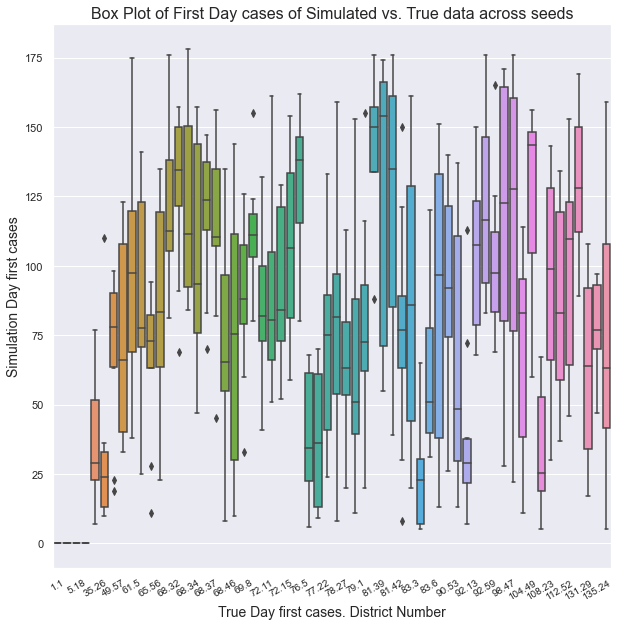

In [153]:
fig, ax = plt.subplots (figsize = (10, 10))
ax = sns.boxplot(
                x='trueDay_sep', 
                y='simDay_firstcase',
                data=ema_plus_gold)
ax.axes.set_title("Box Plot of First Day cases of Simulated vs. True data across seeds", fontsize=16)
ax.set_xlabel("True Day first cases. District Number", fontsize=14)
ax.set_ylabel("Simulation Day first cases", fontsize=14)


# make sure x axis labels are visible
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, size = 10)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
from matplotlib.ticker import FormatStrFormatter
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
#put on same scale
# ax.set(xlim=(0, 179), ylim=(0, 179)) # in true day the max first day is 136, in sim the max first day is 179
# xl, yl = [0,179], [0,179]
# sns.lineplot(xl, yl, linestyle='--', color='red')

# Be sure to only pick integer tick locations.
# import matplotlib.ticker as ticker

# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(path+'plots/district/box_plots/first_cases_dist_10seeds_016_180.png')
# Nice example code here https://stackabuse.com/seaborn-box-plot-tutorial-and-examples/

## Next plot national level trajectory comparisons